# --- Finance Academy: Portfolio Investing ---
# Authors: Ryan Loveless, Inigo Abascal, Carmello Maggio
# April 2025

In [1]:
# Import Required Libraries

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta

# PyPortfolioOpt imports:
from pypfopt import EfficientFrontier, risk_models, expected_returns
import scipy.optimize as opt

In [2]:
# Configuration & Assumptions

Start_Date = "2019-06-01"
End_Date   = "2024-12-31"
risk_free_equity = 0.02      # For CAPM & Sharpe (annual)
risk_free_option = 0.01      # For Black-Scholes pricing (annual)
shares_per_contract = 100
transaction_cost = 0.001     # 0.1% per trade cost

# Parameters for covered call enhancements:
# (Using delta-targeting, the target delta is our key input)
target_delta = 0.3           # Initial target delta (to be optimized)
threshold_vol_option = 0.25  # Initial threshold volatility (annual) for option term decision
short_option_term = 60       # Option term (days) in high volatility periods
long_option_term = 90        # Option term (days) in low volatility periods

# Dynamic weight allocation parameters (for combined portfolio)
high_equity_weight = 0.70    # When SPY volatility is low
low_equity_weight = 0.45     # When SPY volatility is high
vol_threshold = 0.25         # SPY volatility threshold (annual)

# Sector ETF list and SPY Benchmark
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV',
            'XLI', 'XLB', 'XLRE', 'XLK', 'XLU', 'XLC']
benchmark_ticker = 'SPY'

# --- Helper Functions ---

In [3]:
def compute_dynamic_base_buffer(S, sigma, T, r, target_yield=0.015, min_b=0.01, max_b=0.15, step=0.005):
    """
    Compute a dynamic base strike buffer such that the theoretical option premium yield 
    is as close as possible to the target_yield.
    """
    best_b = min_b
    best_diff = float('inf')
    for b in np.arange(min_b, max_b + step, step):
        K = S * (1 + b)
        premium = black_scholes_call(S, K, T, r, sigma)
        yield_est = premium / (S * shares_per_contract)
        diff = abs(yield_est - target_yield)
        if diff < best_diff:
            best_diff = diff
            best_b = b
    return best_b

def delta_targeted_strike(S, T, r, sigma, target_delta=target_delta):
    """
    Compute the call strike K such that under the Black-Scholes model the call delta is equal to target_delta.
    
    K = S * exp(-σ√T * N⁻¹(target_delta) + (r + 0.5σ²)T)
    """
    d_target = norm.ppf(target_delta)
    K = S * np.exp(-sigma * np.sqrt(T) * d_target + (r + 0.5 * sigma**2)*T)
    return K

def dynamic_option_term(sigma, threshold=threshold_vol_option, short_term=short_option_term, long_term=long_option_term):
    """
    Choose option term in days based on current annualized volatility.
    """
    return long_term if sigma < threshold else short_term

def dynamic_weight_allocation(current_vol, low=low_equity_weight, high=high_equity_weight, threshold=vol_threshold):
    """
    Adjust overall equity allocation based on SPY's recent annualized volatility.
    """
    return low if current_vol >= threshold else high

def compute_sector_weights(price_data, etfs, lookback_days=126):
    """
    Compute weights for each ETF based on trailing 6-month performance.
    Negative returns are clipped to zero.
    """
    last_date = price_data.index.max()
    start_date = last_date - pd.Timedelta(days=lookback_days)
    trailing_return = price_data.loc[start_date:last_date, etfs].iloc[-1] / price_data.loc[start_date:last_date, etfs].iloc[0] - 1
    trailing_return = trailing_return.clip(lower=0)
    if trailing_return.sum() == 0:
        weights = pd.Series(1/len(etfs), index=etfs)
    else:
        weights = trailing_return / trailing_return.sum()
    return weights

# --- Black-Scholes Call Option Pricing ---
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.
    """
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# --- Covered Calls ---

In [4]:
# --- Covered Call Simulation for a Single ETF ---
def simulate_covered_call_for_etf(ticker, price_series):
    """
    Simulate daily portfolio values for a covered call strategy on one ETF.
    Uses delta-targeted strike selection and a dynamic option term.
    """
    df = pd.DataFrame({'Price': price_series.dropna()})
    df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
    df['Volatility'] = df['LogReturn'].rolling(window=30).std() * np.sqrt(252)
    df.dropna(inplace=True)
    
    # Monthly option sale dates: first trading day of each month.
    monthly_dates = df.resample('MS').first().index
    monthly_dates = [d for d in monthly_dates if d in df.index]
    
    shares = shares_per_contract
    cash = 0.0
    portfolio_values = []
    dates = []
    active_calls = []  # Each call: {'strike': K, 'expiration': date}
    
    for current_date in df.index:
        S = df.at[current_date, 'Price']
        sigma = df.at[current_date, 'Volatility']
        portfolio_val = cash + shares * S
        dates.append(current_date)
        portfolio_values.append(portfolio_val)
        
        # Check expiration of active options.
        for pos in list(active_calls):
            if current_date >= pos['expiration']:
                K = pos['strike']
                if S > K and shares > 0:
                    cash += shares * K
                    shares = 0
                active_calls.remove(pos)
        
        if current_date in monthly_dates:
            if shares == 0:
                shares = shares_per_contract
                cash -= shares * S
                cash -= (shares * S) * transaction_cost
            # Determine option term dynamically.
            opt_term = dynamic_option_term(sigma)
            T = opt_term / 252.0
            # Use delta-targeted strike selection.
            K = delta_targeted_strike(S, T, risk_free_option, sigma, target_delta=target_delta)
            premium = black_scholes_call(S, K, T, risk_free_option, sigma) * shares_per_contract
            cash += premium
            cash -= (shares * S) * transaction_cost
            expiration_date = current_date + pd.Timedelta(days=opt_term)
            active_calls.append({'strike': K, 'expiration': expiration_date})
    
    return pd.Series(portfolio_values, index=dates)

# --- Covered Call Portfolio ---
def simulate_covered_calls_portfolio(etfs, price_data):
    """
    Run the covered call simulation for each ETF and combine the results using performance-based weights.
    Returns a normalized daily series.
    """
    portfolios = {}
    for ticker in etfs:
        try:
            prices = price_data[ticker]
            portfolios[ticker] = simulate_covered_call_for_etf(ticker, prices)
        except Exception as e:
            print(f"Warning: Simulation for {ticker} failed: {e}")
    if not portfolios:
        raise ValueError("No ETF data available for covered call simulation.")
    sector_weights = compute_sector_weights(price_data, etfs, lookback_days=126)
    combined_df = pd.DataFrame(portfolios).sort_index().ffill()
    weighted_portfolio = combined_df.multiply(sector_weights, axis=1).sum(axis=1)
    normalized = weighted_portfolio / weighted_portfolio.iloc[0]
    return normalized

# --- Equity Portfolio Simulation ---

In [5]:
def simulate_equity_portfolio(etfs, benchmark, price_data, calib_years=2):
    """
    Simulate a quarterly-rebalanced equity portfolio using a rolling calibration window and PyPortfolioOpt.
    Returns a normalized daily series.
    """
    daily_returns = price_data.pct_change().dropna()
    rebalance_dates = daily_returns.resample('QS').first().index
    rebalance_dates = [d for d in rebalance_dates if d >= daily_returns.index[0]]
    
    dates = []
    values = []
    current_value = 1.0
    
    for i, rebalance_date in enumerate(rebalance_dates):
        if rebalance_date > daily_returns.index[-1]:
            break
        window_start = rebalance_date - pd.DateOffset(years=calib_years)
        calib_data = daily_returns.loc[window_start:rebalance_date]
        mu = expected_returns.mean_historical_return(price_data.loc[window_start:rebalance_date], frequency=252)
        Sigma = risk_models.sample_cov(price_data.loc[window_start:rebalance_date], frequency=252)
        ef = EfficientFrontier(mu, Sigma, weight_bounds=(0, 1))
        ef.max_sharpe(risk_free_equity)
        weights = ef.clean_weights()
        optimal_weights = pd.Series(weights)
        if i > 0:
            current_value *= (1 - transaction_cost)
        
        if i < len(rebalance_dates) - 1:
            next_start = rebalance_dates[i + 1]
            period_idx = daily_returns.index[daily_returns.index < next_start]
            period_end = period_idx[-1] if len(period_idx) > 0 else daily_returns.index[-1]
        else:
            period_end = daily_returns.index[-1]
        
        period_returns = daily_returns.loc[rebalance_date:period_end, etfs]
        if rebalance_date not in period_returns.index:
            dates.append(rebalance_date)
            values.append(current_value)
        for day in period_returns.index:
            if day == rebalance_date:
                dates.append(day)
                values.append(current_value)
            daily_ret = np.dot(period_returns.loc[day, etfs], optimal_weights[etfs])
            current_value *= (1 + daily_ret)
            dates.append(day)
            values.append(current_value)
    
    equity_portfolio = pd.Series(values, index=dates)
    equity_portfolio = equity_portfolio[~equity_portfolio.index.duplicated(keep='first')]
    equity_index = equity_portfolio / equity_portfolio.iloc[0]
    return equity_index

# --- Bootstrap Sensitivity Analysis & Risk Metrics ---

In [6]:
def bootstrap_sensitivity(index_series, n_iter=1000, sample_frac=0.5):
    """
    Perform bootstrap resampling on the portfolio's daily returns to assess sensitivity.
    Returns a DataFrame with bootstrap distributions of risk metrics.
    """
    returns = index_series.pct_change().dropna()
    metrics_list = []
    for _ in range(n_iter):
        sample = returns.sample(frac=sample_frac, replace=True)
        sample_series = (1 + sample).cumprod()
        metrics_list.append(compute_risk_metrics(sample_series))
    bootstrap_df = pd.DataFrame(metrics_list, columns=["Cumulative Return", "Annual Return", "Volatility", "Sharpe", "Max Drawdown"])
    return bootstrap_df

def compute_risk_metrics(index_series, risk_free=0.02):
    """
    Compute risk metrics for a normalized index series.
    Returns cumulative return, annualized return, annual volatility, Sharpe ratio, and max drawdown.
    """
    returns = index_series.pct_change().dropna()
    cumulative_return = index_series.iloc[-1] / index_series.iloc[0] - 1
    annual_factor = 252
    annual_return = (index_series.iloc[-1] / index_series.iloc[0])**(annual_factor/len(index_series)) - 1
    ann_vol = returns.std() * np.sqrt(annual_factor)
    sharpe = (annual_return - risk_free) / (ann_vol if ann_vol != 0 else np.nan)
    running_max = index_series.cummax()
    drawdown = (index_series - running_max) / running_max
    max_drawdown = drawdown.min()
    return cumulative_return, annual_return, ann_vol, sharpe, max_drawdown

# --- Optimize Assumptions ---

In [7]:
def objective(params, price_data):
    """
    Objective function to be minimized (negative Sharpe ratio) given a vector of parameters.
    Parameters vector:
      params[0]: target_delta
      params[1]: threshold_vol_option
      params[2]: short_option_term (days)
      params[3]: long_option_term (days)
      params[4]: high_equity_weight
      params[5]: low_equity_weight
      params[6]: vol_threshold
    """
    global target_delta, threshold_vol_option, short_option_term, long_option_term, high_equity_weight, low_equity_weight, vol_threshold
    target_delta = params[0]
    threshold_vol_option = params[1]
    short_option_term = int(round(params[2]))
    long_option_term = int(round(params[3]))
    high_equity_weight = params[4]
    low_equity_weight = params[5]
    vol_threshold = params[6]
    
    try:
        equity_index = simulate_equity_portfolio(etf_list, benchmark_ticker, price_data)
        covered_call_index = simulate_covered_calls_portfolio(etf_list, price_data)
    
        common_start = max(equity_index.index.min(), covered_call_index.index.min())
        full_dates = pd.date_range(start=common_start, end=price_data.index.max(), freq='B')
    
        equity_index_full = equity_index.reindex(full_dates).ffill().bfill()
        covered_call_index_full = covered_call_index.reindex(full_dates).ffill().bfill()
    
        equity_daily_ret = equity_index_full.pct_change().fillna(0)
        option_daily_ret = covered_call_index_full.pct_change().fillna(0)
    
        spy_prices = price_data[benchmark_ticker]
        spy_returns = spy_prices.pct_change().dropna()
        spy_vol = spy_returns.rolling(window=30).std().iloc[-1] * np.sqrt(252)
        dyn_equity_weight = dynamic_weight_allocation(spy_vol)
    
        combined_daily_ret = dyn_equity_weight * equity_daily_ret + (1 - dyn_equity_weight) * option_daily_ret
        combined_index = (1 + combined_daily_ret).cumprod()
    
        _, _, _, sharpe, _ = compute_risk_metrics(combined_index, risk_free=risk_free_equity)
    except Exception as e:
        sharpe = -100  # Penalize if simulation fails
    
    if np.isnan(sharpe):
        return 1000
    return -sharpe  # We want to maximize Sharpe, so minimize negative Sharpe

# Define bounds for each parameter
bounds = [
    (0.25, 0.55),    # target_delta
    (0.15, 0.30),    # threshold_vol_option
    (20, 90),        # short_option_term (days)
    (30, 120),       # long_option_term (days)
    (0.60, 0.80),    # high_equity_weight
    (0.10, 0.50),    # low_equity_weight
    (0.20, 0.40)     # vol_threshold
]

# --- Main Execution ---

In [8]:
if __name__ == "__main__":
    # Download historical price data.
    all_tickers = etf_list + [benchmark_ticker]
    price_data = yf.download(all_tickers, start=Start_Date, end=End_Date, auto_adjust=True)['Close']
    price_data.dropna(inplace=True)
    
    # Run current simulations and print risk metrics.
    equity_index = simulate_equity_portfolio(etf_list, benchmark_ticker, price_data)
    covered_call_index = simulate_covered_calls_portfolio(etf_list, price_data)
    
    common_start = max(equity_index.index.min(), covered_call_index.index.min())
    full_dates = pd.date_range(start=common_start, end=price_data.index.max(), freq='B')
    
    equity_index_full = equity_index.reindex(full_dates).ffill().bfill()
    covered_call_index_full = covered_call_index.reindex(full_dates).ffill().bfill()
    equity_daily_ret = equity_index_full.pct_change().fillna(0)
    option_daily_ret = covered_call_index_full.pct_change().fillna(0)
    
    spy_prices = price_data[benchmark_ticker]
    spy_returns = spy_prices.pct_change().dropna()
    spy_vol = spy_returns.rolling(window=30).std().iloc[-1] * np.sqrt(252)
    dyn_equity_weight = dynamic_weight_allocation(spy_vol)
    print(f"Dynamic equity weight based on SPY volatility ({spy_vol:.2%}): {dyn_equity_weight:.2f}")
    
    combined_daily_ret = dyn_equity_weight * equity_daily_ret + (1 - dyn_equity_weight) * option_daily_ret
    combined_index = (1 + combined_daily_ret).cumprod()
    spy_index = (price_data[benchmark_ticker] / price_data[benchmark_ticker].iloc[0]).reindex(full_dates).ffill().bfill()
    
    strategies = {
        'Equity Portfolio': equity_index_full,
        'Covered Call Strategy': covered_call_index_full,
        'Combined Portfolio': combined_index,
        'SPY Buy & Hold': spy_index
    }
    metrics = []
    for name, series in strategies.items():
        cum_ret, ann_ret, ann_vol, sharpe, max_dd = compute_risk_metrics(series, risk_free=risk_free_equity)
        metrics.append({
            "Strategy": name,
            "Cumulative Return (%)": cum_ret * 100,
            "Annualized Return (%)": ann_ret * 100,
            "Annualized Volatility (%)": ann_vol * 100,
            "Sharpe Ratio": sharpe,
            "Max Drawdown (%)": max_dd * 100
        })
    metrics_df = pd.DataFrame(metrics)
    print("\nRisk Metrics Comparison:")
    print(metrics_df)
    excel_filename = "portfolio_risk_metrics.xlsx"
    metrics_df.to_excel(excel_filename, index=False)
    print(f"\nRisk metrics have been written to {excel_filename}")
    
    bootstrap_results = bootstrap_sensitivity(combined_index, n_iter=500, sample_frac=0.5)
    print("\nBootstrap Sensitivity Analysis (first 5 rows):")
    print(bootstrap_results.head())
    
    # --- Optimization ---
    # Use differential evolution to optimize the covered call parameters (and dynamic weight allocation parameters)
    '''
    result = opt.differential_evolution(objective, bounds, args=(price_data,), maxiter=50, tol=0.01, disp=True)
    print("\nOptimized Parameters:")
    print("target_delta:", result.x[0])
    print("threshold_vol_option:", result.x[1])
    print("short_option_term:", int(round(result.x[2])))
    print("long_option_term:", int(round(result.x[3])))
    print("high_equity_weight:", result.x[4])
    print("low_equity_weight:", result.x[5])
    print("vol_threshold:", result.x[6])
    print("Max Sharpe achieved:", -result.fun)
    '''

[*********************100%***********************]  12 of 12 completed


Dynamic equity weight based on SPY volatility (13.04%): 0.70

Risk Metrics Comparison:
                Strategy  Cumulative Return (%)  Annualized Return (%)  \
0       Equity Portfolio             116.548854              14.641117   
1  Covered Call Strategy             162.870919              18.639185   
2     Combined Portfolio             134.059125              16.228414   
3         SPY Buy & Hold             113.663347              14.369482   

   Annualized Volatility (%)  Sharpe Ratio  Max Drawdown (%)  
0                  24.710561      0.511567        -32.613467  
1                  18.080073      0.920305        -20.609668  
2                  21.351081      0.666403        -28.973312  
3                  20.067725      0.616387        -33.717264  

Risk metrics have been written to portfolio_risk_metrics.xlsx

Bootstrap Sensitivity Analysis (first 5 rows):
   Cumulative Return  Annual Return  Volatility    Sharpe  Max Drawdown
0           0.221427       0.073360    0.198

# --- Visualization ---

[****************      33%                       ]  4 of 12 completed

Fetching historical price data...


[*********************100%***********************]  12 of 12 completed


Running portfolio simulations...
Dynamic equity weight based on SPY volatility (12.43%): 0.70
Generating visualizations...

Risk Metrics Comparison:
                Strategy  Cumulative Return (%)  Annualized Return (%)  \
0       Equity Portfolio             116.548854              14.641117   
1  Covered Call Strategy             162.870919              18.639185   
2     Combined Portfolio             134.059125              16.228414   
3         SPY Buy & Hold             113.663347              14.369482   

   Annualized Volatility (%)  Sharpe Ratio  Max Drawdown (%)  
0                  24.710561      0.511567        -32.613467  
1                  18.080073      0.920305        -20.609668  
2                  21.351081      0.666403        -28.973312  
3                  20.067725      0.616387        -33.717264  
Risk metrics have been written to portfolio_risk_metrics.xlsx


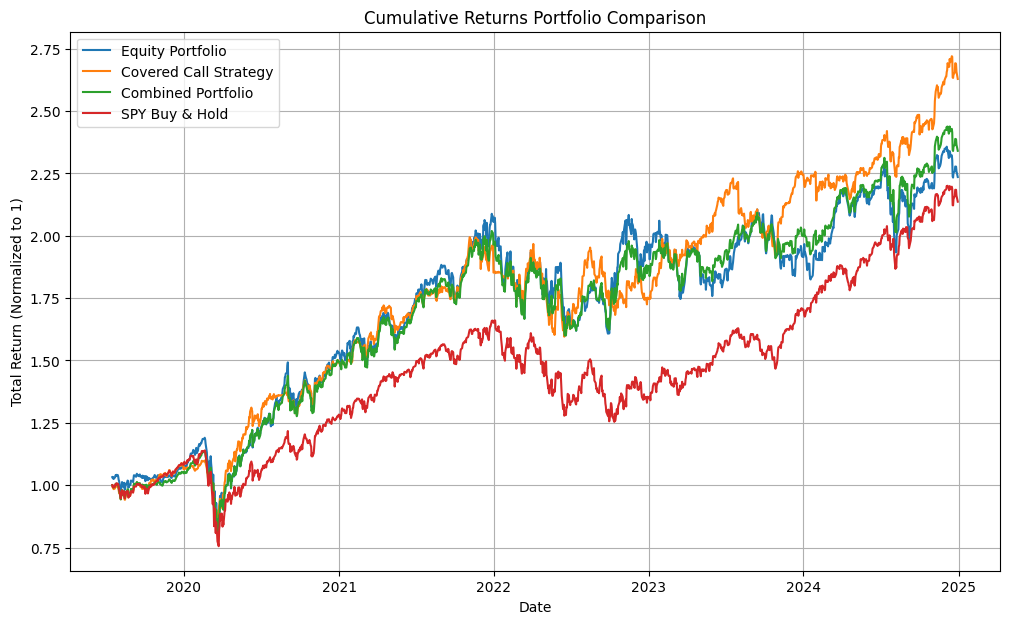

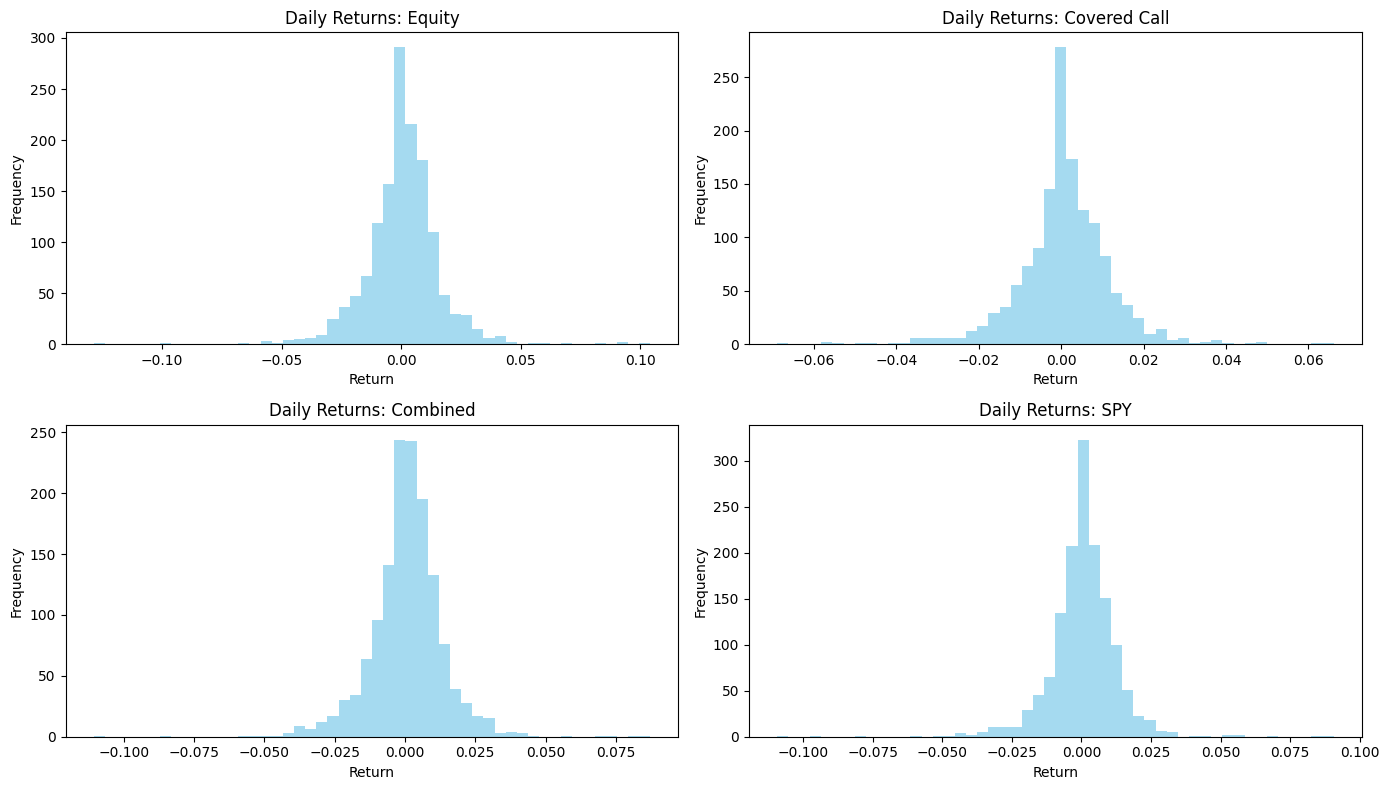

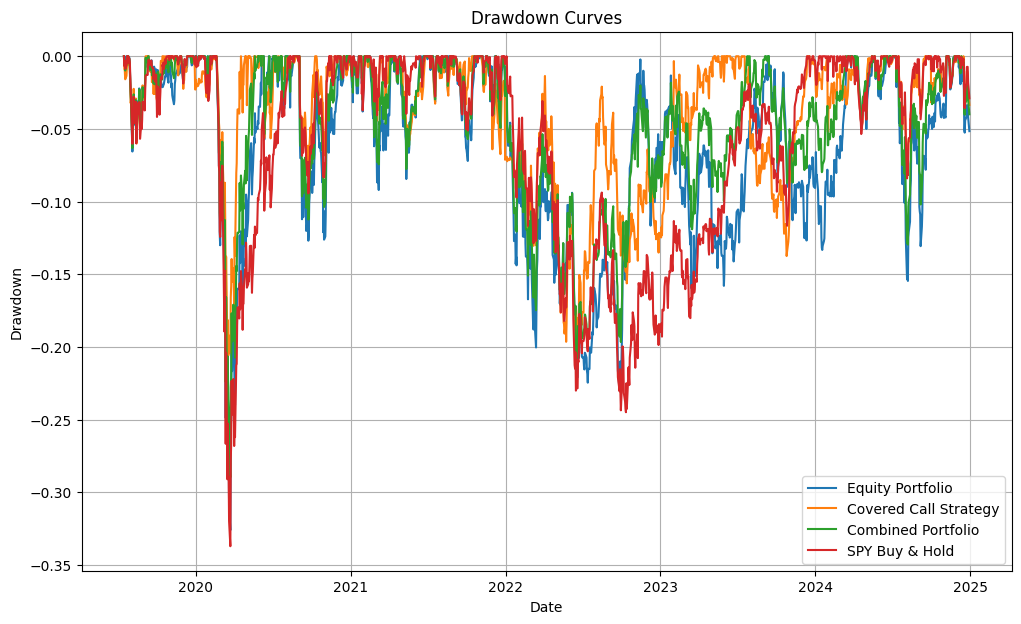

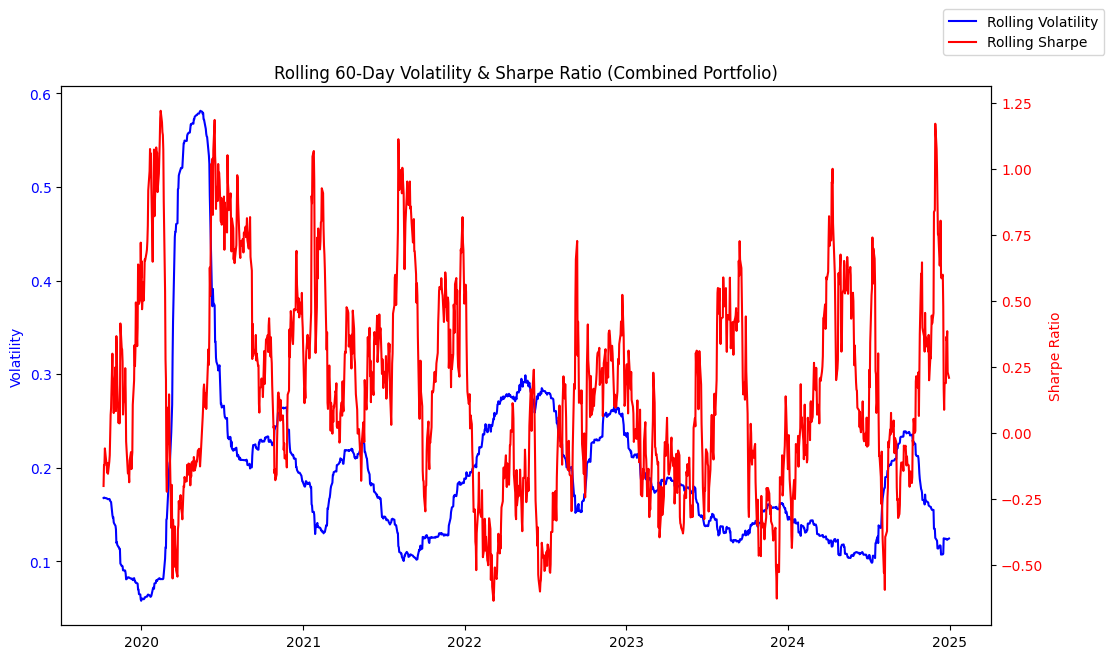

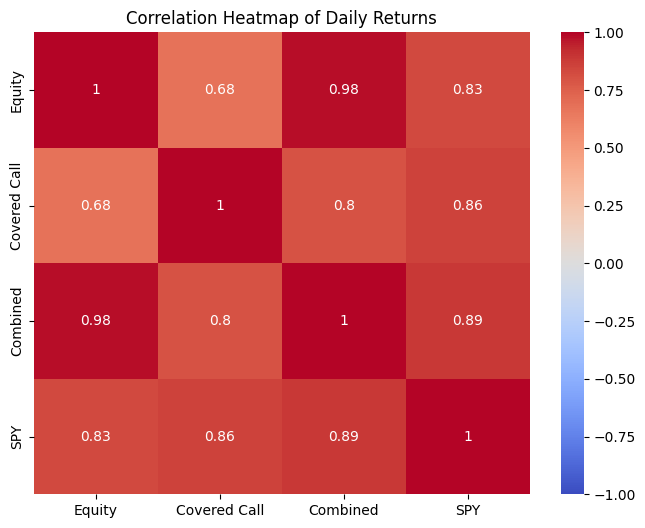

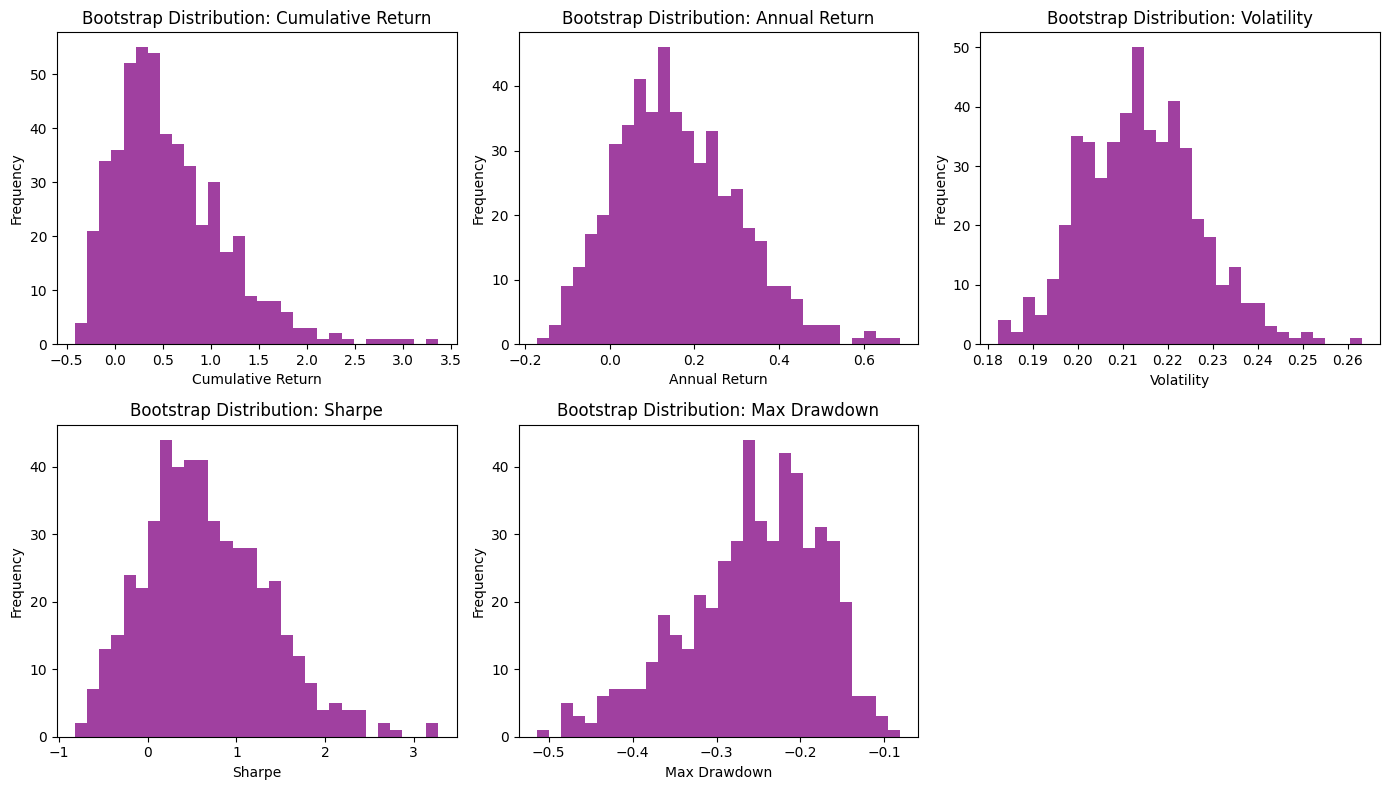

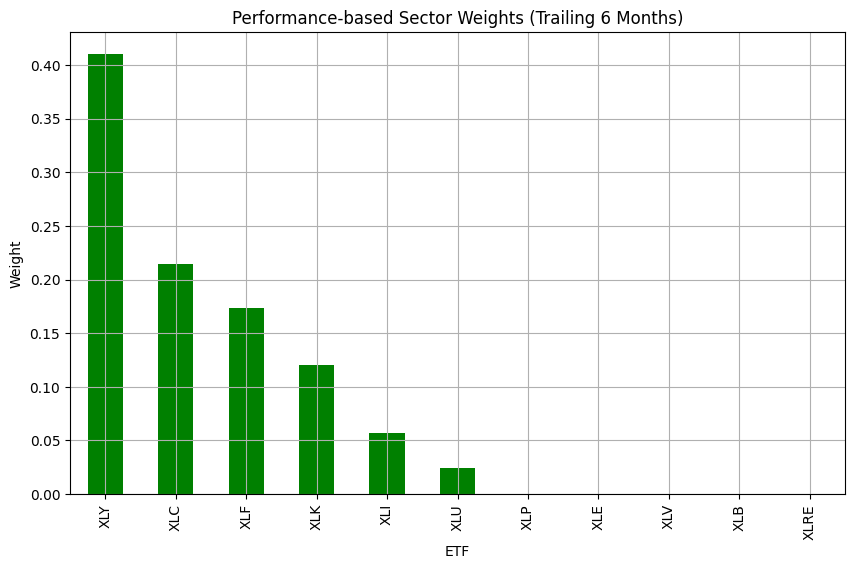

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration (should match portfolio.py) ---
Start_Date = "2019-06-01"
End_Date   = "2024-12-31"
benchmark_ticker = 'SPY'
etf_list = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV',
            'XLI', 'XLB', 'XLRE', 'XLK', 'XLU', 'XLC']

# --- Data Acquisition ---
print("Fetching historical price data...")
all_tickers = etf_list + [benchmark_ticker]
price_data = yf.download(all_tickers, start=Start_Date, end=End_Date, auto_adjust=True)['Close']
price_data.dropna(inplace=True)

# --- Run Portfolio Simulations ---
print("Running portfolio simulations...")
equity_index = simulate_equity_portfolio(etf_list, benchmark_ticker, price_data)
covered_call_index = simulate_covered_calls_portfolio(etf_list, price_data)

# Define common date range from the later of the two series' first dates.
common_start = max(equity_index.index.min(), covered_call_index.index.min())
full_dates = pd.date_range(start=common_start, end=price_data.index.max(), freq='B')

equity_index_full = equity_index.reindex(full_dates).ffill().bfill()
covered_call_index_full = covered_call_index.reindex(full_dates).ffill().bfill()

# Compute daily returns for each strategy.
equity_daily_ret = equity_index_full.pct_change().fillna(0)
option_daily_ret = covered_call_index_full.pct_change().fillna(0)

# Prepare SPY normalized series on the same date range.
spy_index = price_data[benchmark_ticker].reindex(full_dates).ffill().bfill()
spy_index = spy_index / spy_index.iloc[0]

# Compute dynamic equity allocation using SPY volatility.
spy_returns = spy_index.pct_change().dropna()
spy_vol = spy_returns.rolling(window=30).std().iloc[-1] * np.sqrt(252)
dyn_equity_weight = dynamic_weight_allocation(spy_vol)
print(f"Dynamic equity weight based on SPY volatility ({spy_vol:.2%}): {dyn_equity_weight:.2f}")

# Combine equity and covered call strategies using the dynamic equity weight.
combined_daily_ret = dyn_equity_weight * equity_daily_ret + (1 - dyn_equity_weight) * option_daily_ret
combined_index = (1 + combined_daily_ret).cumprod()

# Create a dictionary with strategy series.
strategies = {
    "Equity Portfolio": equity_index_full,
    "Covered Call Strategy": covered_call_index_full,
    "Combined Portfolio": combined_index,
    "SPY Buy & Hold": spy_index
}

# --- Visualization Functions ---

def plot_cumulative_returns(strategy_dict):
    plt.figure(figsize=(12, 7))
    for label, series in strategy_dict.items():
        plt.plot(series.index, series.values, label=label)
    plt.title("Cumulative Returns Portfolio Comparison")
    plt.xlabel("Date")
    plt.ylabel("Total Return (Normalized to 1)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig("output/cumulative_returns.png")

def plot_daily_return_histograms(daily_returns_dict):
    """Plot histograms for daily returns for each strategy, filtering out non-finite values."""
    plt.figure(figsize=(14, 8))
    for i, (label, daily_ret) in enumerate(daily_returns_dict.items()):
        # Filter out any non-finite values
        daily_ret = daily_ret[np.isfinite(daily_ret)]
        if daily_ret.empty:
            print(f"Warning: {label} daily returns are empty or contain no finite values.")
            continue
        plt.subplot(2, 2, i+1)
        plt.hist(daily_ret, bins=50, alpha=0.75, color="skyblue")
        plt.title(f"Daily Returns: {label}")
        plt.xlabel("Return")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("output/daily_return_histograms.png")

def plot_drawdown_curves(strategy_dict):
    plt.figure(figsize=(12, 7))
    for label, series in strategy_dict.items():
        running_max = series.cummax()
        drawdown = (series - running_max) / running_max
        plt.plot(drawdown.index, drawdown.values, label=label)
    plt.title("Drawdown Curves")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig("output/drawdown_curves.png")

def plot_rolling_metrics(series, window=60):
    daily_ret = series.pct_change().dropna()
    rolling_vol = daily_ret.rolling(window=window).std() * np.sqrt(252)
    # Compute rolling cumulative return over the window
    rolling_return = (1 + daily_ret).rolling(window=window).apply(np.prod, raw=True) - 1
    rolling_sharpe = (rolling_return - risk_free_equity) / rolling_vol
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.plot(rolling_vol.index, rolling_vol, color="blue", label="Rolling Volatility")
    ax1.set_ylabel("Volatility", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax2 = ax1.twinx()
    ax2.plot(rolling_sharpe.index, rolling_sharpe, color="red", label="Rolling Sharpe")
    ax2.set_ylabel("Sharpe Ratio", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    plt.title(f"Rolling {window}-Day Volatility & Sharpe Ratio (Combined Portfolio)")
    fig.legend(loc="upper right", bbox_to_anchor=(1,1))
    plt.savefig("output/rolling_metrics.png")

def plot_correlation_heatmap(daily_returns_dict):
    data = {}
    for label, ret in daily_returns_dict.items():
        data[label] = ret
    returns_df = pd.DataFrame(data)
    corr_matrix = returns_df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap of Daily Returns")
    plt.savefig("output/correlation_heatmap.png")

def plot_bootstrap_histograms(bootstrap_df):
    plt.figure(figsize=(14, 8))
    metrics = bootstrap_df.columns
    for i, met in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.hist(bootstrap_df[met].dropna(), bins=30, alpha=0.75, color="purple")
        plt.title(f"Bootstrap Distribution: {met}")
        plt.xlabel(met)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("output/bootstrap_histograms.png")

def plot_sector_weights(sector_weights):
    plt.figure(figsize=(10, 6))
    sector_weights.sort_values(ascending=False).plot(kind="bar", color="green")
    plt.title("Performance-based Sector Weights (Trailing 6 Months)")
    plt.xlabel("ETF")
    plt.ylabel("Weight")
    plt.grid(True)
    plt.savefig("output/sector_weights.png")

# --- Generate Visualizations ---
print("Generating visualizations...")

# 1. Plot Cumulative Returns
plot_cumulative_returns(strategies)

# 2. Plot Daily Return Histograms
daily_returns_strategies = {
    "Equity": equity_index_full.pct_change().dropna(),
    "Covered Call": covered_call_index_full.pct_change().dropna(),
    "Combined": combined_index.pct_change().dropna(),
    "SPY": spy_index.pct_change().dropna()
}
plot_daily_return_histograms(daily_returns_strategies)

# 3. Plot Drawdown Curves
plot_drawdown_curves(strategies)

# 4. Plot Rolling Metrics for Combined Portfolio
plot_rolling_metrics(combined_index, window=60)

# 5. Plot Correlation Heatmap of Daily Returns
plot_correlation_heatmap(daily_returns_strategies)

# 6. Plot Bootstrap Sensitivity Histograms
bootstrap_results = bootstrap_sensitivity(combined_index, n_iter=500, sample_frac=0.5)
plot_bootstrap_histograms(bootstrap_results)

# 7. Plot Sector Weights
sector_weights = compute_sector_weights(price_data, etf_list, lookback_days=126)
plot_sector_weights(sector_weights)

# 8. Compute and Export Risk Metrics
metrics_list = []
for label, series in strategies.items():
    cum_ret, ann_ret, ann_vol, sharpe, max_dd = compute_risk_metrics(series, risk_free=risk_free_equity)
    metrics_list.append({
        "Strategy": label,
        "Cumulative Return (%)": cum_ret * 100,
        "Annualized Return (%)": ann_ret * 100,
        "Annualized Volatility (%)": ann_vol * 100,
        "Sharpe Ratio": sharpe,
        "Max Drawdown (%)": max_dd * 100
    })
metrics_df = pd.DataFrame(metrics_list)
print("\nRisk Metrics Comparison:")
print(metrics_df)
metrics_df.to_excel("portfolio_risk_metrics.xlsx", index=False)
print("Risk metrics have been written to portfolio_risk_metrics.xlsx")
